<a href="https://colab.research.google.com/github/DarkLord-13/Machine-Learning-01/blob/main/CapuchinBirdAudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip install Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

100% 603M/604M [00:06<00:00, 89.6MB/s]
100% 604M/604M [00:06<00:00, 92.9MB/s]


In [5]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
!pip install tensorflow_io
import tensorflow_io as tfio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 22.5 MB/s eta 0:00:00


In [6]:
def load_wav_16k_mono(filename): # this converts the file to 16K Hz and single channel(mono)
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal, reduces file size as well
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
from zipfile import ZipFile

dataset = '/content/z-by-hp-unlocked-challenge-3-signal-processing.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('dataset is extracted')

dataset is extracted


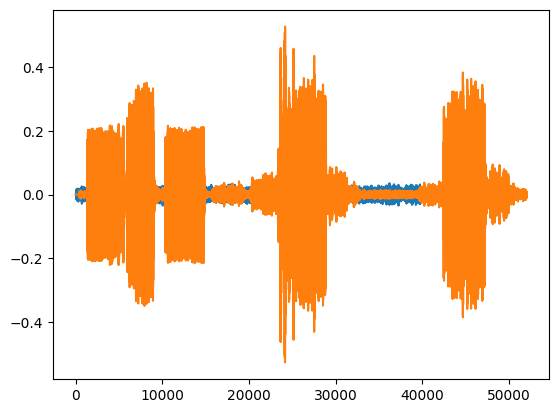

In [8]:
# Plot Wave
wave = load_wav_16k_mono('/content/Parsed_Capuchinbird_Clips/XC114131-0.wav')
nwave = load_wav_16k_mono('/content/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav')
plt.plot(wave)
plt.plot(nwave)
plt.show()

# yellow-> capuchin bird, blue-> not a capuchin bird

Here we are converting the audio files into image representation so that we can apply image classification.

In [9]:
POS = '/content/Parsed_Capuchinbird_Clips'
NEG = '/content/Parsed_Not_Capuchinbird_Clips'

In [10]:
# Create Tensorflow Datasets
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [11]:
# Add labels and Combine Positive and Negative Samples (labels -> 1 or 0 for +ve and -ve respectively)
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

data = positives.concatenate(negatives) # Combine Positive and Negative Samples

In [12]:
print(len(positives))
print(len(negatives))

217
593


Determine Average Length of a Capuchin Call

In [13]:
# Calculate Wave Cycle Length
lengths = []
for file in os.listdir('/content/Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wav_16k_mono('/content/Parsed_Capuchinbird_Clips/'+file)
    lengths.append(len(tensor_wave))

In [14]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [15]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [16]:
tf.math.reduce_max(lengths)

# 80000/16000 = 5sec

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

Build Preprocessing Function to Convert to Spectrogram

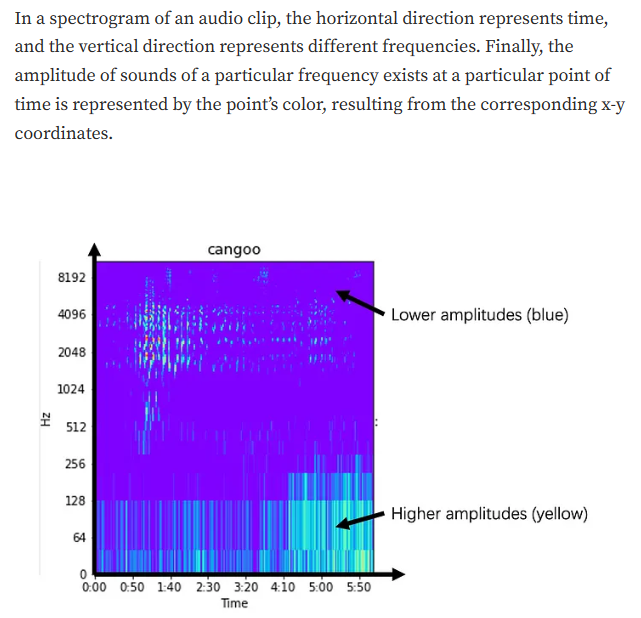

In [17]:
# Build Preprocessing Function
# you can make changes in 48000 here
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path) # loads the dataset into 16k waveform
    wav = wav[:48000] # this grabs only the first 48000 steps in the recording
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0) # the above 2 LOC adds padding(zeroes) to audio files less than 48000
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32) # creates the spectrogram
    spectrogram = tf.abs(spectrogram) # removes the negatives |abs|
    spectrogram = tf.expand_dims(spectrogram, axis=2) # converts to grayscale
    return spectrogram, label

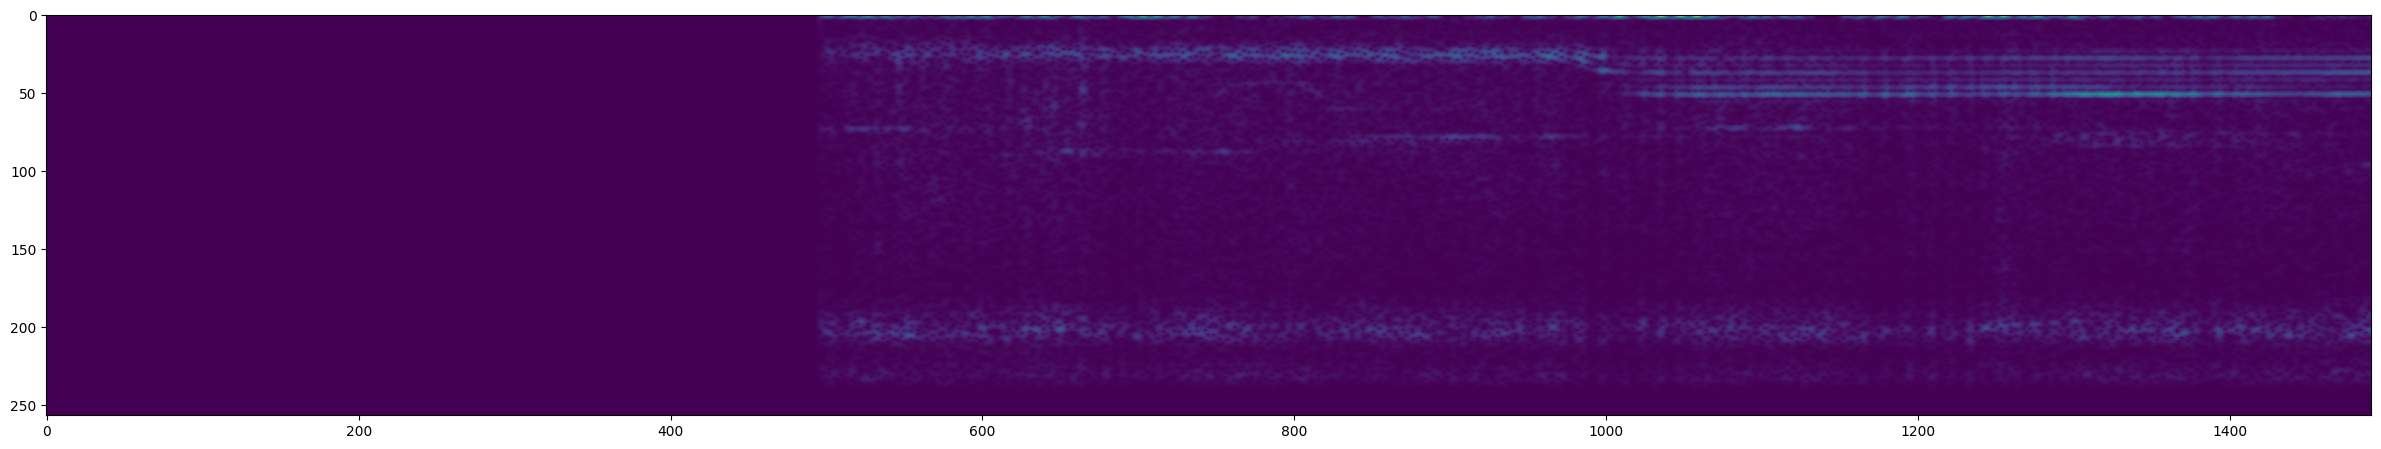

In [18]:
# Test Out the Function and Viz the Spectrogram
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

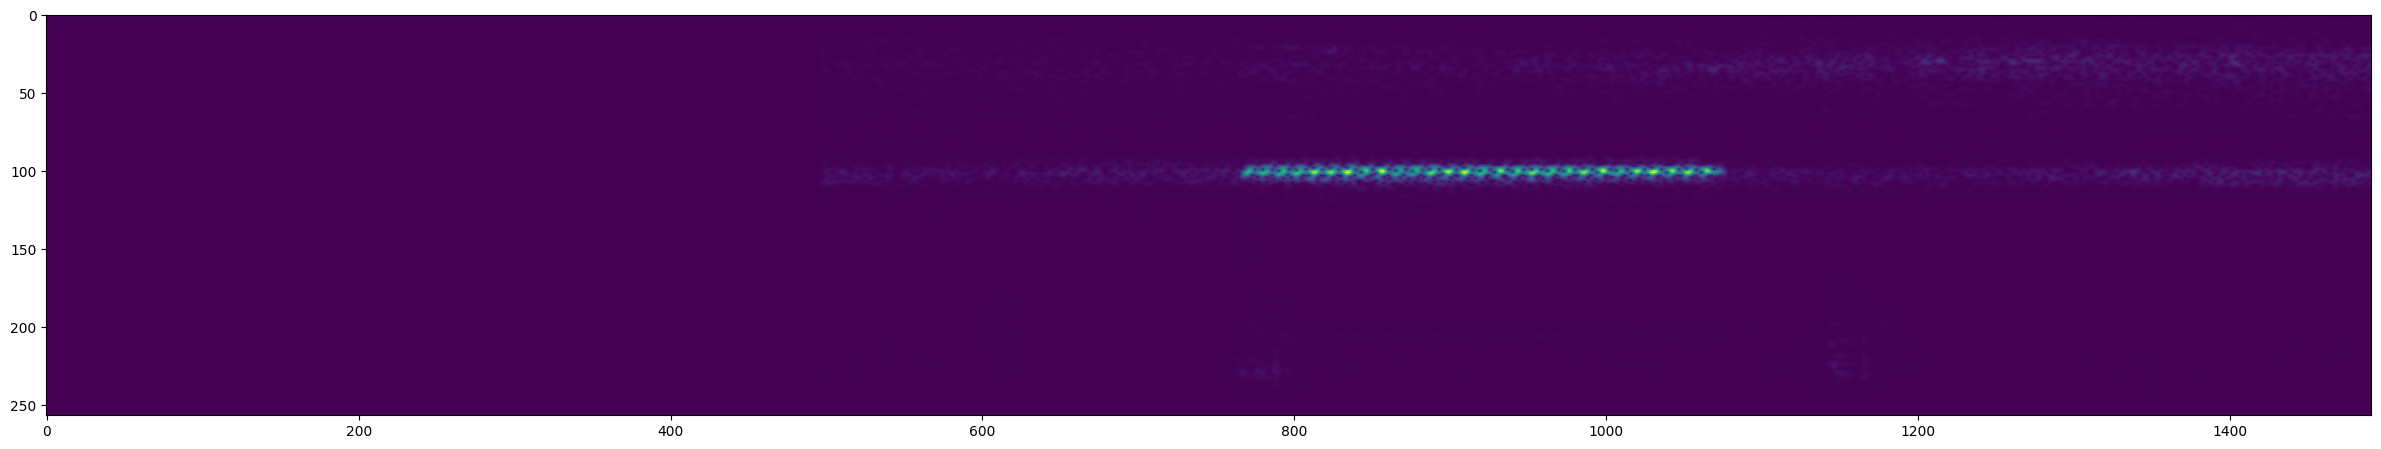

In [19]:
# Test Out the Function and Viz the Spectrogram
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Create Training and Testing Partitions

In [20]:
# Create a Tensorflow Data Pipeline
data = data.map(preprocess) # converts all the audio files to spectrogram and stores it in data with its label
data = data.cache()
data = data.shuffle(buffer_size=1000) # shuffles positives and negatives
data = data.batch(16)
data = data.prefetch(8) # prefetches 8 files to prevent bottleneck

In [21]:
len(data)*0.7 # 70% for training

35.699999999999996

In [22]:
# Split into Training and Testing Partitions
train = data.take(36)
test = data.skip(36).take(15)

In [23]:
# Test One Batch
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

Build Deep Learning Model

In [24]:
# Load Tensorflow Dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [25]:
# Build Sequential Model, Compile and View Summary
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adamax', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Fit Model, View Loss and KPI Plots

hist = model.fit(train, epochs=4, validation_data=test)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

Epoch 1/4


ResourceExhaustedError: ignored

Make a Prediction on a Single Clip

In [ ]:
# Get One Batch and Make a Prediction
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

In [ ]:
# Convert Logits to Classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
print(yhat)
print(y_test)

In [ ]:
# total no. of capuchin calls in 1 batch
print(tf.math.reduce_sum(yhat))
print(tf.math.reduce_sum(y_test))